Для решения данной задачи был взят dataset с уже размеченными данными и координатами углов boundingBoxes

<a href = "https://www.kaggle.com/dataturks/clothing-item-detection-for-ecommerce"> ссылка </a> на данные 

Использовал предобученную модель на pytorch (Faster R-CNN), дообучаю на найденных данных

Работал в коллабе, поскольку нет в доступе gpu


In [2]:
from google.colab import files
files.upload()
import utils

Saving utils.py to utils.py


In [0]:
import collections
import torch.utils.data
from PIL import Image, ImageFile
from torchvision import transforms
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import os
import numpy as np
import pandas as pd
import torch
from PIL import Image
import torchvision.transforms as T
from skimage import io
import requests
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt


### Считываем данные для обучения

In [0]:
file = requests.get('https://raw.githubusercontent.com/i311297/Files/i311297-patch-1/E-commerce%20Tagging%20for%20clothing%20.json')
file = file.json()

In [0]:
def createDF(file):
  img = []
  label = []
  xmin = []
  ymin = []
  xmax = []
  ymax = []
  width = []
  heigth = []
  for i in file:
    img.append(i['content'])
    label.append(i['annotation'][0]['label'][0])
    xmin.append(round(float(i['annotation'][0]['points'][0]['x']) * float(i['annotation'][0]['imageWidth'])))
    ymin.append(round(float(i['annotation'][0]['points'][0]['y'])* float(i['annotation'][0]['imageHeight'])))
    xmax.append(round(float(i['annotation'][0]['points'][1]['x']) * float(i['annotation'][0]['imageWidth'])))
    ymax.append(round(float(i['annotation'][0]['points'][1]['y']) * float(i['annotation'][0]['imageHeight'])) )
    width.append(round(float(i['annotation'][0]['imageWidth'])))
    heigth.append(round(float(i['annotation'][0]['imageHeight'])))
  data = np.array([img, width, heigth, xmin, ymin, xmax, ymax, label]).T
  return pd.DataFrame(data, columns=['img', 'width', 'heigth', 'xmin', 'ymin', 'xmax', 'ymax', 'label'])  


df = createDF(file)
labels = {'Tops': 1,
          'Jackets': 2,
          'Tshirts': 3,
          'Shirts': 4,
          'Skirts': 5,
          'Shoes': 6,
          'Jeans': 7,
          'sunglasses': 8,
          'Trousers': 9}
df['label'] = df['label'].replace(labels)
df['ymin'] = df['ymin'].replace({0:1}) 
df['xmin'] = df['xmin'].replace({0:1}) 
df = df.drop(index = 251)
df.index = range(503) 
df[['xmin', 'xmax', 'ymin', 'ymax']] = df[['xmin', 'xmax', 'ymin', 'ymax']].astype('int64')
def imgarray(i):
  try:
    return io.imread(i)
  except:
    return "none"
im = np.array(df.img)
imgar = list(map(imgarray, im))

Посмотрим распределение классов

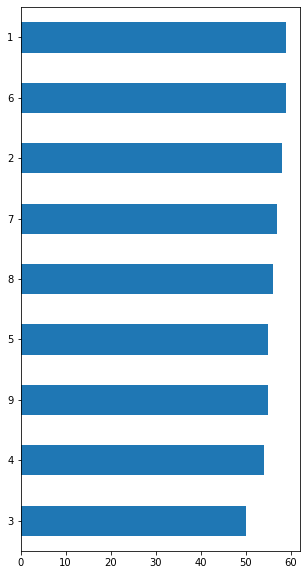

In [6]:
plt.figure(figsize = (5,10));
df.label.value_counts().sort_values().plot(kind = 'barh')

Данные хорошие, классы распределены более менее равномерно

### Иду по туториалу Pytorch

In [0]:
class clothesDS(object):
    def __init__(self, df, img):
        self.df = df
        self.height = 256
        self.width = 256
        self.transforms = transforms
        self.index = range(len(img))
        self.img = img

    def __getitem__(self, idx):
        img = self.img[idx]
        
        img = transforms.ToPILImage()(img)
        classes = []
        classes.append(df.label[idx])
        boxes = []
        xmin = float(df['xmin'][idx])
        xmax = float(df['xmax'][idx])
        ymin = float(df['ymin'][idx])
        ymax = float(df['ymax'][idx])
        boxes.append([xmin, ymin, xmax, ymax])
        classes = torch.as_tensor(classes)
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((1,), dtype=torch.int64)
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = classes
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        return transforms.ToTensor()(img), target

    def __len__(self):
        return len(self.index)

dataset_train = clothesDS(df,imgar)



data_loader = torch.utils.data.DataLoader(dataset_train,
    batch_size=4, shuffle=True, num_workers = 8,
    collate_fn=lambda x: tuple(zip(*x)))

In [0]:
def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq):
    model.train()
    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', utils.SmoothedValue(window_size=1, fmt='{value:.6f}'))
    header = 'Epoch: [{}]'.format(epoch)

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1. / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = utils.warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor)

    for images, targets in metric_logger.log_every(data_loader, print_freq, header):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())

        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = utils.reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])

In [9]:
num_classes = 10
device = torch.device('cuda:0')

model_ft = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model_ft.roi_heads.box_predictor.cls_score.in_features
model_ft.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model_ft.to(device)

for param in model_ft.parameters():
    param.requires_grad = True


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [0]:
params = [p for p in model_ft.parameters() if p.requires_grad]
optimizer = torch.optim.RMSprop(params, lr=0.000005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=5,
                                               gamma=0.1)

### Обучаю

In [11]:
num_epochs = 6
for epoch in range(num_epochs):
    train_one_epoch(model_ft, optimizer, data_loader, device, epoch, print_freq=10)
    lr_scheduler.step()

Epoch: [0]  [  0/126]  eta: 0:07:38  lr: 0.000000  loss: 2.2122 (2.2122)  loss_classifier: 2.0907 (2.0907)  loss_box_reg: 0.0562 (0.0562)  loss_objectness: 0.0137 (0.0137)  loss_rpn_box_reg: 0.0515 (0.0515)  time: 3.6382  data: 0.4326  max mem: 10431
Epoch: [0]  [ 10/126]  eta: 0:03:45  lr: 0.000000  loss: 2.1291 (1.9304)  loss_classifier: 2.0106 (1.8111)  loss_box_reg: 0.0779 (0.0737)  loss_objectness: 0.0033 (0.0043)  loss_rpn_box_reg: 0.0412 (0.0413)  time: 1.9457  data: 0.0445  max mem: 10855
Epoch: [0]  [ 20/126]  eta: 0:03:09  lr: 0.000001  loss: 1.0563 (1.2301)  loss_classifier: 0.9369 (1.1074)  loss_box_reg: 0.0842 (0.0798)  loss_objectness: 0.0040 (0.0052)  loss_rpn_box_reg: 0.0352 (0.0376)  time: 1.6965  data: 0.0065  max mem: 10855
Epoch: [0]  [ 30/126]  eta: 0:02:42  lr: 0.000001  loss: 0.2502 (0.9056)  loss_classifier: 0.1430 (0.7903)  loss_box_reg: 0.0718 (0.0772)  loss_objectness: 0.0051 (0.0051)  loss_rpn_box_reg: 0.0266 (0.0329)  time: 1.5523  data: 0.0080  max mem: 10

### Проверяю работу на рандомных картинках из интернета

In [0]:
def Pred(url, model, device):
  img = io.imread(url)
  imageTo = transforms.ToTensor()(img)
  model.eval()
  with torch.no_grad():
    prediction = model([imageTo.to(device)])
  box, label, score = [prediction[0]['boxes'][0], prediction[0]['labels'][0], prediction[0]['scores'][0]]  
  return img, box.cpu().numpy(), label.cpu().numpy(), score.cpu().numpy() 

In [0]:
urls =[
       'https://avatars.mds.yandex.net/get-marketpic/245136/market_wQ3XFyxrBP6qt-OjSholtg/600x800',
       'https://avatars.mds.yandex.net/get-marketpic/1894027/market_pLiVagkZv-WRxBe7rfgX3w/600x800',
       'https://avatars.mds.yandex.net/get-mpic/1808939/img_id6504907657078898948.jpeg/orig',
       'https://i.pinimg.com/736x/0d/f6/d8/0df6d89e4f20c23346e1289ce143dd0e--different-kinds-winter-shoes.jpg',
       'https://avatars.mds.yandex.net/get-marketpic/941727/market__q7Q2vM19k7JFITwMReBIA/600x800',
       'https://a.lmcdn.ru/pi/img600x866/H/E/HE002EMHAFA3_9567889_1_v1.jpg'
       ]
lst = [Pred(i, model_ft, device) for i in urls]



##### Функция для прорисовки bounding boxes

In [0]:
classes = {1: 'Top',
 2: 'Jacket',
 3: 'Tshirt',
 4: 'Shirt',
 5: 'Skirt',
 6: 'Shoes',
 7: 'Jeans',
 8: 'Sunglasses',
 9: 'Trousers'}
def drawBoundingBox(imgcv,box, label, score,classes):
  imgcv=cv2.cvtColor(imgcv, cv2.COLOR_BGR2RGB)
  
  x1,y1,x2,y2 = box[0], box[1], box[2], box[3]
  y3=int(y1+20)

  cv2.rectangle(imgcv,(x1,y1),(x2,y2),(0,0,0),4)
  cv2.putText(imgcv,str(classes[int(label)]),(int(x1+10),y3),cv2.FONT_HERSHEY_TRIPLEX,0.7,(0,0,0),1)
  cv2.putText(imgcv,'prob ' +str(round(float(score),2)),(int(x2-100),y3),cv2.FONT_HERSHEY_TRIPLEX,0.5,(0,0,0),1)
  return imgcv 

In [0]:
imgRes = [drawBoundingBox(k[0],k[1],k[2],k[3],classes) for k in lst]

In [0]:
def showI(imgRes):
    cv2_imshow(cv2.resize(imgRes,(400,540)))


##### Результаты (bounding box, label and probability)

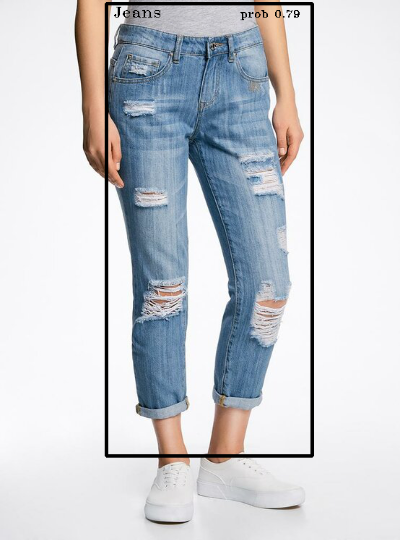

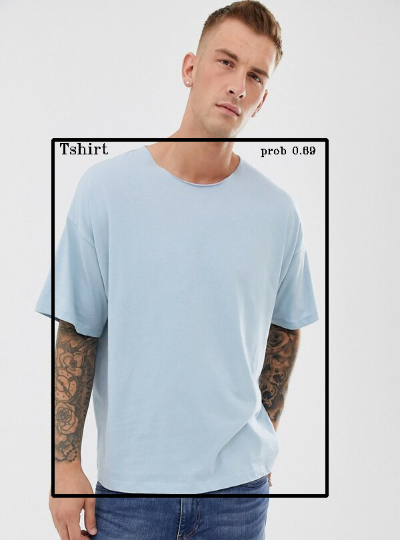

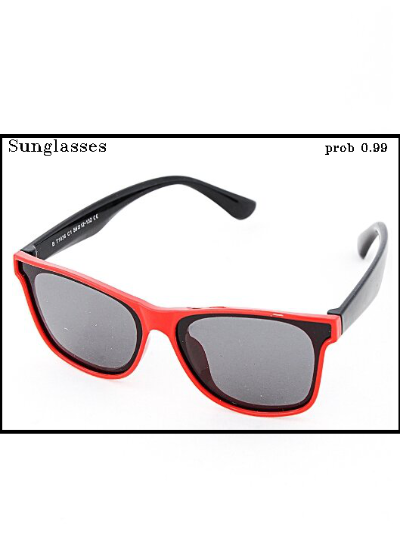

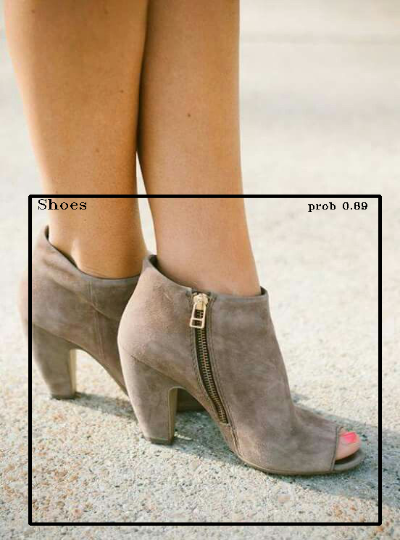

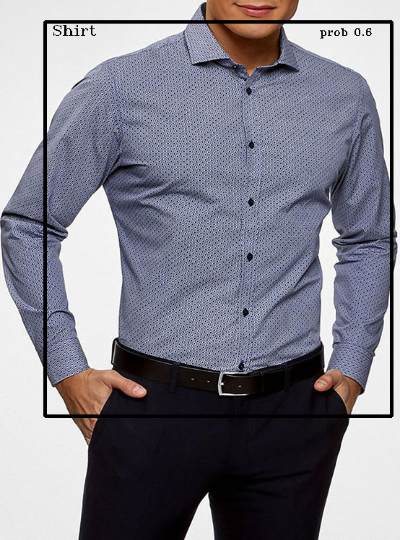

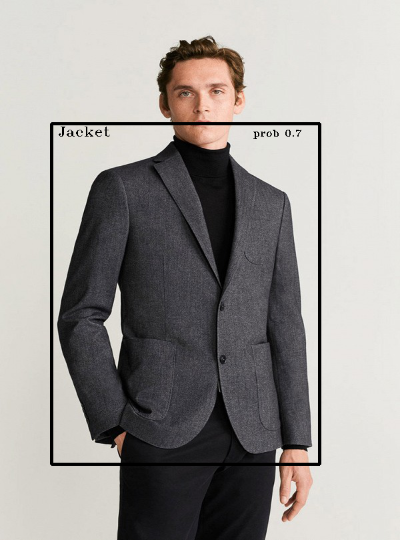

[None, None, None, None, None, None]

In [158]:
list(map(showI,imgRes))